# Loading Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial import distance
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

# Functions Used

In [2]:
def player_projection(player_name):
    player_projection = final_df[final_df['Name'] == player_name]
    return player_projection

In [3]:
def similarity_scores(players_df_grp, player_names, player_name):
    
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(players_df_grp)
    
    scaled_data = pd.DataFrame(scaled_data, columns= [ 'G', 'PA', 'AB', 'R', 'HR', 'RBI', 'SB', 'AVG'])
    scaled_data['Name'] = player_names.Name
    
    player = scaled_data[scaled_data['Name'] == player_name]
    
    scaled_data = scaled_data.groupby('Name').sum()
    player = player.groupby('Name').sum()
    
    similiarity_score = distance.cdist(scaled_data, player, 'euclidean')
    
    player_names['Similiarity_Score'] = similiarity_score
    player_names['Similiarity_Score'] = round(player_names['Similiarity_Score'],2)
    
    return player_names

In [4]:
def weighted_seasons(season_df, seaonal_weight):
    weighted_stats = []
    for col_name in fantasy_categories:
        value = season_df[col_name] * seaonal_weight
        weighted_stats.append(value)
    return weighted_stats

# Loading Data

In [5]:
forcast_data = pd.read_csv(r'C:\Users\ranih\OneDrive\Desktop\Python For Real\Github\Data\Baseball\Hitting\Fangraphs\2017-2019_custom_report_hitting_metrics_3.csv')
forcast_data.head()

,Name,Season,Age,G,PA,AB,R,HR,RBI,SB,...,EV,LA,Barrels,Barrel%,maxEV,HardHit%,Spd,wRC+,WAR,playerid
0,Mookie Betts,2018,25,136,614,520,129,32,80,30,...,92.3,18.5,57,13.10%,110.6,50.20%,7.0,185,10.4,13611
1,Mike Trout,2018,26,140,608,471,101,39,79,24,...,91.2,18.6,54,15.30%,118.0,46.00%,5.9,188,9.6,10155
2,Christian Yelich,2019,27,130,580,489,100,44,97,30,...,93.3,11.3,59,15.80%,117.9,48.70%,6.2,175,7.8,11477
3,Mike Trout,2017,25,114,507,402,92,33,72,22,...,88.8,18.0,38,12.00%,114.7,40.50%,6.2,180,6.8,10155
4,Mike Trout,2019,27,134,600,470,110,45,104,11,...,90.9,22.2,62,17.50%,116.6,43.80%,4.9,178,8.5,10155


In [6]:
print("Dataframe Rows: ", forcast_data.shape[0])
print("Dataframe Columns: ", forcast_data.shape[1])

Dataframe Rows:  838
Dataframe Columns:  43


# Feature Selection

In [7]:
forcast_data =  forcast_data[['Name','Season','G','PA','AB','R','HR','RBI','SB','AVG']]
forcast_data.head()

,Name,Season,G,PA,AB,R,HR,RBI,SB,AVG
0,Mookie Betts,2018,136,614,520,129,32,80,30,0.346
1,Mike Trout,2018,140,608,471,101,39,79,24,0.312
2,Christian Yelich,2019,130,580,489,100,44,97,30,0.329
3,Mike Trout,2017,114,507,402,92,33,72,22,0.306
4,Mike Trout,2019,134,600,470,110,45,104,11,0.291


# Data Preprocessing

In [8]:
forcast_data = forcast_data[(forcast_data['Season'] >= 2017) & (forcast_data['Season'] < 2020)]
forcast_data.head()

,Name,Season,G,PA,AB,R,HR,RBI,SB,AVG
0,Mookie Betts,2018,136,614,520,129,32,80,30,0.346
1,Mike Trout,2018,140,608,471,101,39,79,24,0.312
2,Christian Yelich,2019,130,580,489,100,44,97,30,0.329
3,Mike Trout,2017,114,507,402,92,33,72,22,0.306
4,Mike Trout,2019,134,600,470,110,45,104,11,0.291


In [9]:
name_df_final = forcast_data['Name'].value_counts().to_frame().reset_index()
name_df_final.columns.values[0] = 'Name'
name_df_final.columns.values[1] = "seasons_of_data"
forcast_data = name_df_final.merge(forcast_data, how = 'inner', on = ['Name'])
forcast_data.head()

,Name,seasons_of_data,Season,G,PA,AB,R,HR,RBI,SB,AVG
0,Hunter Renfroe,3,2018,117,441,403,53,26,68,2,0.248
1,Hunter Renfroe,3,2019,140,494,440,64,33,64,5,0.216
2,Hunter Renfroe,3,2017,122,479,445,51,26,58,3,0.231
3,Dansby Swanson,3,2019,127,545,483,77,17,65,10,0.251
4,Dansby Swanson,3,2018,136,533,478,51,14,59,10,0.238


In [10]:
forcast_data_grouped = forcast_data.groupby(['Name','Season']).sum()
forcast_data_grouped = forcast_data[forcast_data['seasons_of_data'] >= 3]
forcast_data_grouped = forcast_data_grouped.groupby(['Name','Season']).sum()
forcast_data_grouped.head()

seasons_of_data    G   PA   AB    R  HR  RBI  SB    AVG
Name         Season                                                         
A.J. Pollock 2017                  3  112  466  425   73  14   49  20  0.266
             2018                  3  113  460  413   61  21   65  13  0.257
             2019                  3   86  342  308   49  15   47   5  0.266
Aaron Judge  2017                  3  155  678  542  128  52  114   9  0.284
             2018                  3  112  498  413   77  27   67   6  0.278

In [11]:
fantasy_cats_restind = forcast_data_grouped.reset_index()

# Forcasting Player Statistics

In [12]:
fantasy_categories = fantasy_cats_restind[['G', 'PA', 'AB', 'R', 'HR', 'RBI','SB', 'AVG']]
fantasy_categories.head(3)

,G,PA,AB,R,HR,RBI,SB,AVG
0,112,466,425,73,14,49,20,0.266
1,113,460,413,61,21,65,13,0.257
2,86,342,308,49,15,47,5,0.266


In [13]:
season_2017 = fantasy_cats_restind[fantasy_cats_restind['Season'] == 2017]
season_2018 = fantasy_cats_restind[fantasy_cats_restind['Season'] == 2018]
season_2019 = fantasy_cats_restind[fantasy_cats_restind['Season'] == 2019]

In [14]:
season_2017 = season_2017.groupby(['Name','Season']).mean()
season_2018 = season_2018.groupby(['Name','Season']).mean()
season_2019 = season_2019.groupby(['Name','Season']).mean()

In [15]:
# seasonal weight per season
three_season_2017 = .20
three_season_2018 = .40
three_season_2019 = .40

In [16]:
weighted_stats_2017 = weighted_seasons(season_2017, three_season_2017)
weighted_stats_2018 = weighted_seasons(season_2018, three_season_2018)
weighted_stats_2019 = weighted_seasons(season_2019, three_season_2019)

In [17]:
# tranposing each list below to a seasonal dataframe
forcast_2017 = pd.DataFrame(weighted_stats_2017)
forcast_2017 = forcast_2017.T

In [18]:
forcast_2018 = pd.DataFrame(weighted_stats_2018)
forcast_2018 = forcast_2018.T

In [19]:
forcast_2019 = pd.DataFrame(weighted_stats_2019)
forcast_2019 = forcast_2019.T

In [20]:
# merging each seasonal dataframe into 1 dataframe
dfs  = [forcast_2017,forcast_2018,forcast_2019]
three_seasons_final_forcast = pd.concat(dfs)
three_seasons_final_forcast.reset_index(inplace=True)
three_seasons_final_forcast =  three_seasons_final_forcast.groupby(['Name']).sum()
three_seasons_final_forcast.drop('Season',axis=1,inplace=True)

In [21]:
three_seasons_final_forcast.head(3)

,G,PA,AB,R,HR,RBI,SB,AVG
Name,,,,,,,,
A.J. Pollock,102.0,414.0,373.4,58.6,17.2,54.6,11.2,0.2624
Aaron Judge,116.6,513.6,424.8,86.4,32.0,71.6,5.4,0.2768
Adam Frazier,130.2,474.8,430.0,63.8,9.2,44.6,4.2,0.2772


In [22]:
# rounding average for a cleaner read
avg = three_seasons_final_forcast['AVG']
avg = round(avg,3)

In [23]:
# adding average as a column
three_seasons_final_forcast = round(three_seasons_final_forcast.iloc[:,0:7],0)
three_seasons_final_forcast['AVG'] = avg

# Forcast for 2021 season

In [24]:
final_df = three_seasons_final_forcast.copy().reset_index()
final_df_grp = final_df.groupby('Name').sum()
player_names = final_df.copy()

# Player Analysis / Data Visualization

# Player Tool

In [25]:
player_name = input("Enter player name: ")
plt_df = forcast_data[forcast_data['Name'] == player_name]
projection = player_projection(player_name)
similarity_score = similarity_scores(final_df_grp, player_names ,player_name)
projection_grp = projection.groupby('Name').mean()
similarity_score_grp = similarity_score.groupby('Name').mean()
print("")
print("")
print(player_name, "2021 projection:")
print("")
print(projection_grp)
print("")
print("List of players that are similar to ", player_name)
print("")
print(similarity_score_grp.sort_values('Similiarity_Score')[['Similiarity_Score']].iloc[1:6,0:9])
print("")
print("2021 Projections of similar players")
print("")
print(similarity_score_grp.sort_values('Similiarity_Score')[['G','PA','AB','R','HR','RBI','SB','AVG']].iloc[1:6,0:9])
print("")
print("Three year average for ", player_name)
print("")
print("Games: ", round(plt_df["G"].mean(),0))
print("Plate Apperances: ", round(plt_df["PA"].mean(),0)) 
print("Runs: ", round(plt_df["R"].mean(),0)) 
print("Homeruns: ", round(plt_df["HR"].mean(),0)) 
print("Runs Batted In: ", round(plt_df["RBI"].mean(),0)) 
print("Stolen Bases: ", round(plt_df["SB"].mean(),0))
print("Batting Average: ", round(plt_df["AVG"].mean(),3))

Enter player name: Mike Trout


Mike Trout 2021 projection:

                G     PA     AB      R    HR   RBI    SB    AVG
Name                                                           
Mike Trout  132.0  585.0  457.0  103.0  40.0  88.0  18.0  0.302

List of players that are similar to  Mike Trout

                  Similiarity_Score
Name                               
Christian Yelich               1.90
George Springer                2.20
Javier Baez                    2.27
Cody Bellinger                 2.27
Trevor Story                   2.41

2021 Projections of similar players

                      G     PA     AB      R    HR   RBI    SB    AVG
Name                                                                 
Christian Yelich  142.0  631.0  546.0  107.0  36.0  99.0  24.0  0.318
George Springer   133.0  596.0  519.0  102.0  31.0  84.0   6.0  0.279
Javier Baez       148.0  584.0  549.0   91.0  30.0  93.0  15.0  0.283
Cody Bellinger    154.0  626.0  542.0   99.0  37.0  96.0 

# Data Visualization


Mike Trout 2017-2019 seasonal trend: 


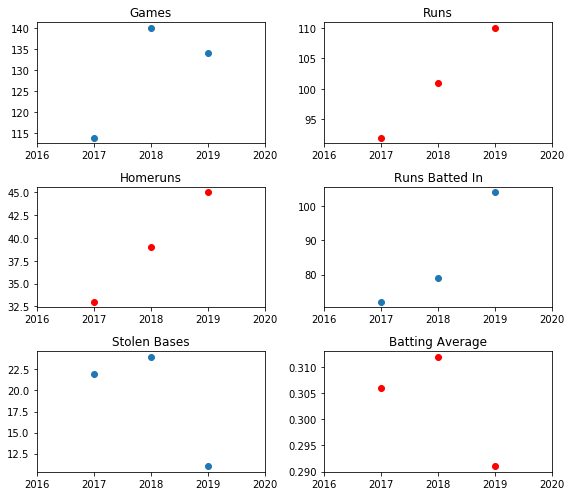

In [26]:
print("")
print(player_name, '2017-2019 seasonal trend: ')
fig, ax = plt.subplots(3, 2,figsize=(8,7) ) # allows for multiple plots in the same layout

# top 2 plots
ax[0,0].plot(plt_df['Season'],plt_df['G'], "o")
ax[0,0].set_xlim([2016,2020])
ax[0, 0].set_title('Games')

ax[0,1].plot(plt_df['Season'],plt_df['R'], "ro")
ax[0,1].set_xlim([2016,2020])
ax[0,1].set_title('Runs')

# middle 2 plots
ax[1,0].plot(plt_df['Season'],plt_df['HR'], "ro")
ax[1,0].set_xlim([2016,2020])
ax[1, 0].set_title('Homeruns')

ax[1,1].plot(plt_df['Season'],plt_df['RBI'], "o")
ax[1,1].set_xlim([2016,2020])
ax[1, 1].set_title('Runs Batted In')

# bottom 2 plots
ax[2,0].plot(plt_df['Season'],plt_df['SB'], "o")
ax[2,0].set_xlim([2016,2020])
ax[2, 0].set_title('Stolen Bases')

ax[2,1].plot(plt_df['Season'],plt_df['AVG'], "ro")
ax[2,1].set_xlim([2016,2020])
ax[2, 1].set_title('Batting Average')


fig.tight_layout()
plt.show()